In [45]:
%matplotlib inline
import cv2
import fastai
from fastai.vision.all import *
import os
import numpy as np
import ipywidgets as widgets
import PIL
import chess
import webbrowser

In [32]:
def get_board(PILimg):
    img = np.array(PILimg) 
    imgblu = cv2.GaussianBlur(img, (3, 3), 0)
    imgray = cv2.cvtColor(imgblu, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    block_size = 50
    board_size = 8 * block_size
    max_area = 0
    for c in contours:
        area = cv2.contourArea(c)
        if area > 2000:
            peri = cv2.arcLength(c, True)
            poly = cv2.approxPolyDP(c, 0.01 * peri, True)
            if len(poly) == 4 and area > max_area:
                max_area = area
                board_c = poly
    if board_c is not None:
        #cv2.drawContours(img, [board_c], 0, (0, 255, 0), 3)
        points = np.vstack(board_c).squeeze()
        board = four_point_transform(img, points)
        return board


def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

def pred_to_fen(predictions):
    fen = ""
    empty = 0
    for i, p in enumerate(predictions):
        p = int(p)
        if i % 8 == 0 and i != 0:
            if empty > 0:
                fen += str(empty)
                empty = 0
            fen += "/"

        if p == 0:
            empty += 1
            if i == 63:
                fen += str(empty)
        else:
            if empty > 0:
                fen += str(empty)
                empty = 0
            fen += chr(p)
    return fen

#return the 64 squares of the board from image
def get_squares(PILimg):
    img = np.array(PILimg)
    img = cv2.resize(img, (400, 400))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.asarray(img)
    vsplit = np.split(img, 8, 0)
    vsplit = np.asarray(vsplit)
    squares = [np.split(s, 8, 1) for s in vsplit]
    squares = np.asarray(squares)
    squares = squares.reshape(64, 50, 50)
    return squares

In [9]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

r2qkr2/3p1pR1/3Q3p/p7/2Bpn3/1P5b/3P1P1P/2KR4


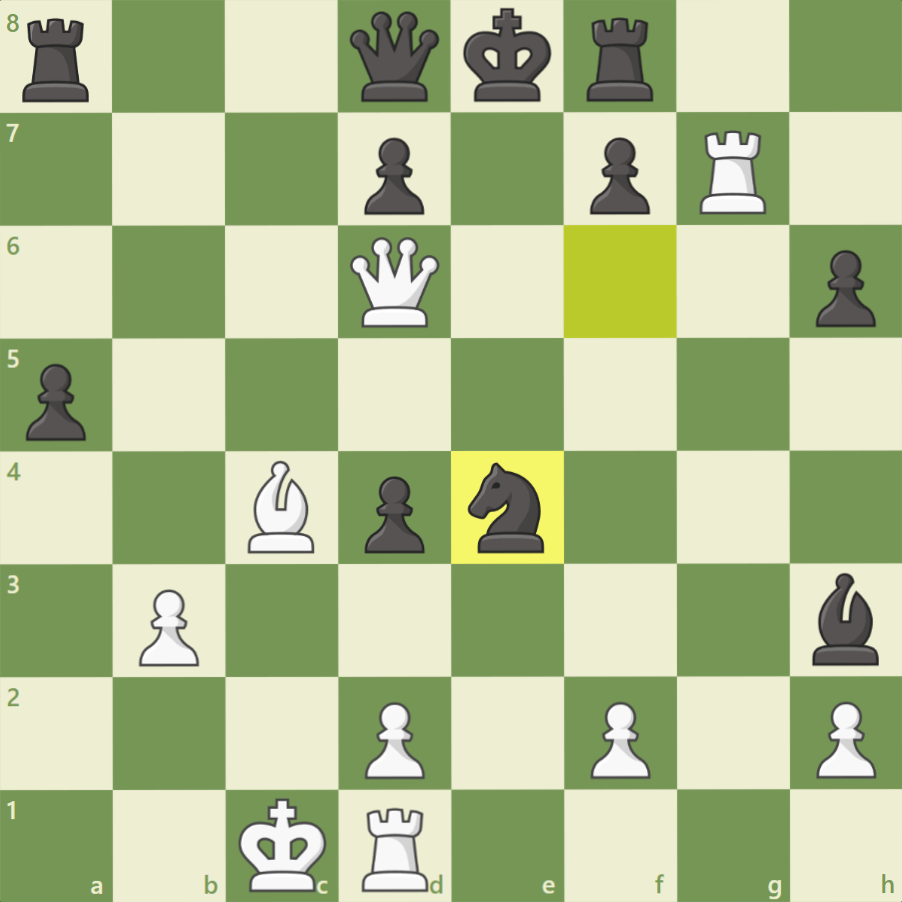

In [63]:
img = PILImage.create(btn_upload.data[-1])
board = get_board(img)

model_path = Path('C:\Datasets\CHESS_PIECES')
learn = load_learner(model_path / 'export.pkl')

squares = get_squares(board)
predictions = []
for s in squares:
    pred_class, pred_idx, outputs = learn.predict(s)
    predictions.append(pred_class)
    
pred_fen = pred_to_fen(predictions)
print(pred_fen)
webbrowser.open('https://lichess.org/analysis/' + pred_fen)
board = PILImage.create(board)
board